In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import preprocessing as prc
import joblib
import numpy as np

In [2]:
scaler  = joblib.load("../models/scaler")
model  = joblib.load("../models/forest.sav")

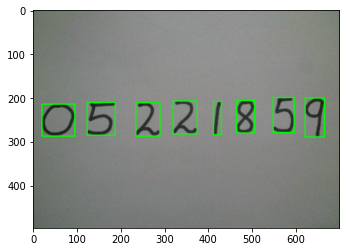

In [3]:
image = cv2.imread('../photos/3.jpeg')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 88, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

preprocessed_digits = []

for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # Box display
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    
    digit = thresh[y:y+h, x:x+w]
    
    # Resizing that digit to (18, 18)
    resized_digit = cv2.resize(digit, (18,18))
    
    # Padding the digit with 5 pixels of (zeros) in each side as in MNIST
    padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
    
    preprocessed_digits.append(padded_digit)
plt.imshow(image, cmap="gray")
plt.show()
    
inp = np.array(preprocessed_digits)

Precidition: [0]




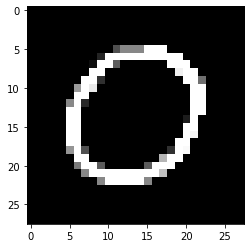

Precidition: [2]




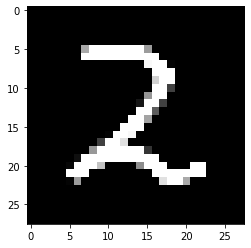

Precidition: [5]




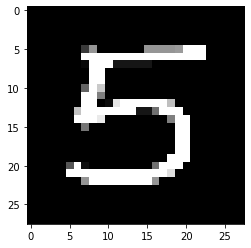

Precidition: [1]




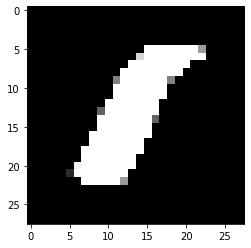

Precidition: [2]




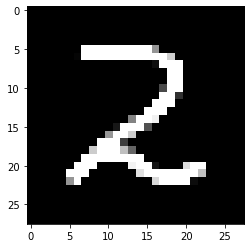

Precidition: [8]




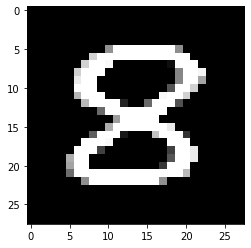

Precidition: [3]




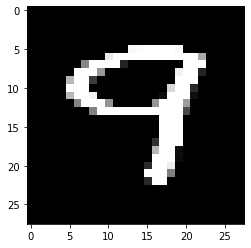

Precidition: [5]




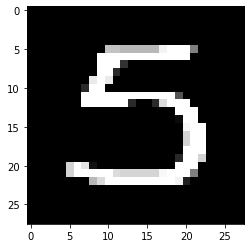

In [4]:
for digit in preprocessed_digits: 
    trs1 = digit.reshape(1, 28, 28, 1)
    trs2 = np.reshape(trs1, (1, 784))
    trs = scaler.transform(trs2)
    prediction = model.predict(trs)  
    print (f"Precidition: {prediction}\n\n")
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()